# Libraries

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from keras.utils.np_utils import to_categorical
import tensorflow
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# Dataset processing

In [73]:
df = pd.read_csv("datasets/df_ML.csv")

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Operon ID                  649 non-null    object 
 1   Operon name                649 non-null    object 
 2   Operon strand              649 non-null    object 
 3   TU ID                      649 non-null    object 
 4   TU name                    648 non-null    object 
 5   TU first gene              649 non-null    object 
 6   Promoter ID                649 non-null    object 
 7   Promoter name              649 non-null    object 
 8   Sigma factor               649 non-null    object 
 9   Promoter sequence          649 non-null    object 
 10  Promoter -35 box start     620 non-null    float64
 11  Promoter -35 box end       620 non-null    float64
 12  Promoter -35 box sequence  620 non-null    object 
 13  Promoter -10 box start     636 non-null    float64

# EDA

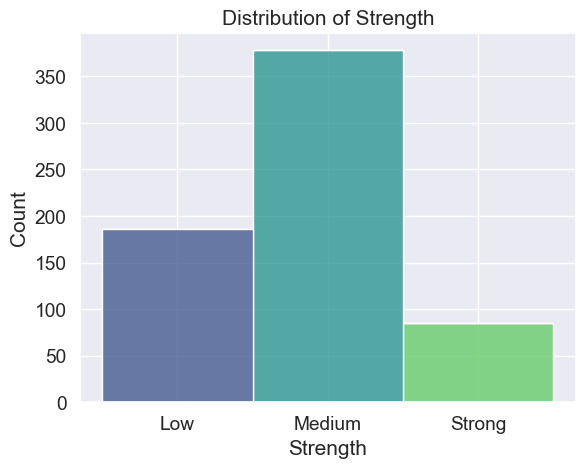

In [75]:
df['Strength'] = df['Strength'].astype('category')

sns.histplot(data=df, x='Strength', hue='Strength', multiple='stack', palette='viridis', legend=None)

plt.xticks(ticks=[0, 1, 2], labels=["Low", "Medium", "Strong"])
plt.title("Distribution of Strength")
plt.xlabel('Strength')
plt.ylabel('Count')
plt.show()

In [76]:
def get_sequence_in_columns(df):
    return pd.concat([df, df['Promoter sequence'].str.upper().apply(lambda x: pd.Series(list(x))).add_prefix('pos_')], axis=1)

In [77]:
# encode promoters sequences
df_2= df[['Promoter sequence', "Strength"]]
df_2 = get_sequence_in_columns(df_2)
df_2 = df_2.drop(columns='Promoter sequence')
encoder_df_2 = OneHotEncoder(sparse_output=False)
encoded_df_2 = encoder_df_2.fit_transform(df_2)
encoded_column_names_df_2 = encoder_df_2.get_feature_names_out()
df_2 = pd.DataFrame(encoded_df_2, columns=encoded_column_names_df_2)

## Correlation matrix

In [78]:
# -35 box
df_boxes = pd.DataFrame()
for col in df_2.columns:
    if col.startswith('pos_45') or col.startswith('pos_46') or col.startswith('pos_47') or col.startswith('pos_48') or col.startswith('pos_49') or col.startswith('pos_50') or col.startswith('pos_51') or col.startswith('pos_52') or col.startswith('pos_53') or col.startswith('pos_54') or col.startswith('pos_55') or col.startswith('pos_56'):
        df_boxes[col] = df_2[col]

# -10 box
df_boxes = pd.DataFrame()
for col in df_2.columns:
    if col.startswith('pos_50') or col.startswith('pos_51') or col.startswith('pos_52') or col.startswith('pos_53') or col.startswith('pos_54') or col.startswith('pos_55') or col.startswith('pos_56'):
        df_boxes[col] = df_2[col]

In [79]:
df_boxes['Strength_0'] = df_2['Strength_0']
df_boxes['Strength_1'] = df_2['Strength_1']
df_boxes['Strength_2'] = df_2['Strength_2']
correlation_matrix = df_boxes.corr()

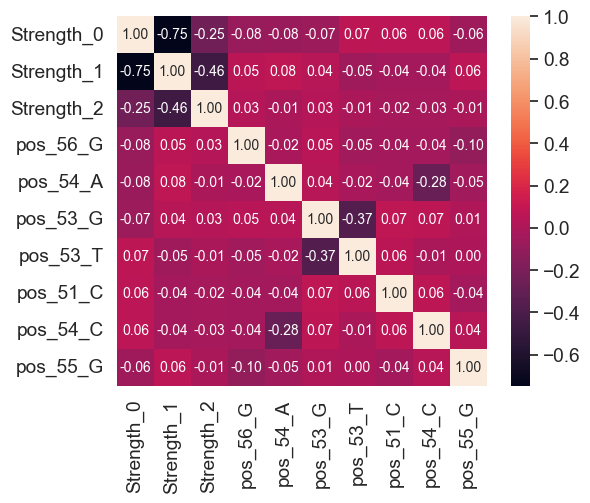

In [80]:
# correlation between boxes and Strength 0
k = 10 #number of variables
cols = abs(correlation_matrix["Strength_0"]).sort_values(ascending=False).nlargest(k).index
cm = np.corrcoef(df_2[cols].values.T) 
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

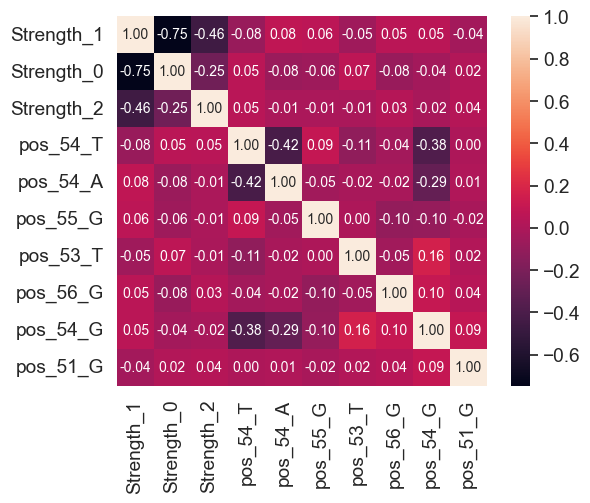

In [81]:
# correlation between boxes and Strength 1
k = 10 #number of variables
cols = abs(correlation_matrix["Strength_1"]).sort_values(ascending=False).nlargest(k).index
cm = np.corrcoef(df_2[cols].values.T) 
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

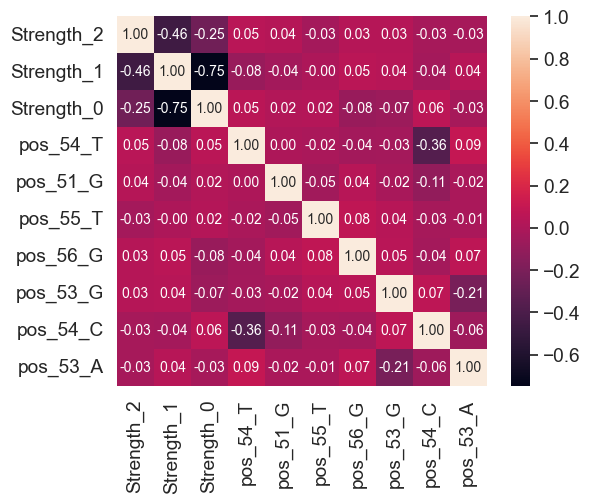

In [82]:
# correlation between boxes and Strength 2
k = 10 #number of variables
cols = abs(correlation_matrix["Strength_2"]).sort_values(ascending=False).nlargest(k).index
cm = np.corrcoef(df_2[cols].values.T) 
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# ML models

In [83]:
df_train, df_test, y_train, y_test = train_test_split(df, df["Strength"], test_size=0.1, stratify=df["Strength"], random_state=42)

In [84]:
df_train_ML = df_train[['Promoter sequence', "Strength"]]
df_test_ML = df_test[['Promoter sequence', "Strength"]]

In [85]:
df_train_ML = get_sequence_in_columns(df_train_ML)
df_test_ML = get_sequence_in_columns(df_test_ML)

In [86]:
X_ML_train = df_train_ML.drop(columns=['Promoter sequence', "Strength"])

X_ML_test = df_test_ML.drop(columns=['Promoter sequence', "Strength"])

y_ML_train = df_train["Strength"]
y_ML_test = df_test["Strength"]

In [87]:
encoder = OneHotEncoder(sparse_output=False)
encoded_X_ML_train = encoder.fit_transform(X_ML_train)
encoded_column_names = encoder.get_feature_names_out()
encoded_X_ML_test = encoder.transform(X_ML_test)

In [88]:
X_ML_train = pd.DataFrame(encoded_X_ML_train, columns=encoded_column_names)
X_ML_test = pd.DataFrame(encoded_X_ML_test, columns=encoded_column_names)

In [89]:
KNN_model = KNeighborsClassifier()
Logit_model = LogisticRegression()
DecTree_model = DecisionTreeClassifier()
RF_model = RandomForestClassifier()
GB_model = GradientBoostingClassifier()
XGB_model = XGBClassifier()

In [90]:
def run_model(model, X_train, y_train, X_test, y_test):
    L=[]
    model.fit(X_train, y_train)
    y_hat_train = model.predict(X_train)
    y_hat_test = model.predict(X_test)
    accuracy_train = accuracy_score(y_train,y_hat_train)
    accuracy_test = accuracy_score(y_test,y_hat_test)
    L.append(accuracy_train)
    L.append(accuracy_test)
    return L

In [91]:
list_of_models = [KNN_model, Logit_model, DecTree_model, RF_model, GB_model, XGB_model]

In [92]:
L=[]
for elem in list_of_models:
    try:
        L.append(run_model(elem, X_ML_train, y_ML_train, X_ML_test, y_ML_test))
    except:
        None
L

[[0.6643835616438356, 0.5230769230769231],
 [0.928082191780822, 0.47692307692307695],
 [1.0, 0.4307692307692308],
 [1.0, 0.5692307692307692],
 [1.0, 0.49230769230769234],
 [1.0, 0.46153846153846156]]

In [93]:
RF_model

RandomForestClassifier()

In [94]:
model_RF = RandomForestClassifier()
params = {'criterion': ['entropy', 'gini'], 
          'max_depth': [5, 7], 
          'max_features': [0.3, 0.7], 
          'max_samples': [0.8, 0.5], 
          'max_leaf_nodes': [10, 30], 
          'min_impurity_decrease': [0.05], 
          'min_samples_split': [5, 10], 
          'n_estimators': [100] }

scoring = ['accuracy']

grid_solver = GridSearchCV(estimator = model_RF, 
                           param_grid = params, 
                           scoring = scoring,
                           cv = 5,
                           refit = 'accuracy',
                           verbose = 1) 

model_result_RF = grid_solver.fit(X_ML_train, y_ML_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [95]:
features_importances = model_result_RF.best_estimator_.feature_importances_
features_importances

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

In [96]:
features_names = model_result_RF.best_estimator_.feature_names_in_
features_names

array(['pos_0_A', 'pos_0_C', 'pos_0_G', 'pos_0_T', 'pos_1_A', 'pos_1_C',
       'pos_1_G', 'pos_1_T', 'pos_2_A', 'pos_2_C', 'pos_2_G', 'pos_2_T',
       'pos_3_A', 'pos_3_C', 'pos_3_G', 'pos_3_T', 'pos_4_A', 'pos_4_C',
       'pos_4_G', 'pos_4_T', 'pos_5_A', 'pos_5_C', 'pos_5_G', 'pos_5_T',
       'pos_6_A', 'pos_6_C', 'pos_6_G', 'pos_6_T', 'pos_7_A', 'pos_7_C',
       'pos_7_G', 'pos_7_T', 'pos_8_A', 'pos_8_C', 'pos_8_G', 'pos_8_T',
       'pos_9_A', 'pos_9_C', 'pos_9_G', 'pos_9_T', 'pos_10_A', 'pos_10_C',
       'pos_10_G', 'pos_10_T', 'pos_11_A', 'pos_11_C', 'pos_11_G',
       'pos_11_T', 'pos_12_A', 'pos_12_C', 'pos_12_G', 'pos_12_T',
       'pos_13_A', 'pos_13_C', 'pos_13_G', 'pos_13_T', 'pos_14_A',
       'pos_14_C', 'pos_14_G', 'pos_14_T', 'pos_15_A', 'pos_15_C',
       'pos_15_G', 'pos_15_T', 'pos_16_A', 'pos_16_C', 'pos_16_G',
       'pos_16_T', 'pos_17_A', 'pos_17_C', 'pos_17_G', 'pos_17_T',
       'pos_18_A', 'pos_18_C', 'pos_18_G', 'pos_18_T', 'pos_19_A',
       'pos_19_C',

In [97]:
print("Train")
y_pred_train=model_result_RF.predict(X_ML_train)
print("Accuracy:", accuracy_score(y_ML_train,y_pred_train))
probs_train=model_result_RF.predict_proba(X_ML_train)

print("Test")
y_pred_test=model_result_RF.predict(X_ML_test)
print("Accuracy:", accuracy_score(y_ML_test,y_pred_test))
probs=model_result_RF.predict_proba(X_ML_test)

Train
Accuracy: 0.5821917808219178
Test
Accuracy: 0.5846153846153846


# Neural Networks

## Multilayer perceptron

In [98]:
model = Sequential()

# First layer
model.add(Dense(50, activation='relu', input_shape=(X_ML_train.shape[1],), kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Second layer
model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

history = model.fit(X_ML_train, y_ML_train, epochs=200, batch_size=32, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 50)                16250     
                                                                 
 batch_normalization_4 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 50)                2550      
                                                                 
 batch_normalization_5 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 50)               

In [99]:
loss_train, accuracy_train = history.model.evaluate(X_cnn_train, y_cnn_train)
loss_test, accuracy_test = history.model.evaluate(X_cnn_test, y_cnn_test)
print('----TRAIN----')
print(f'Loss: {loss_train}, Accuracy: {accuracy_train}')
print('----TEST----')
print(f'Loss: {loss_test}, Accuracy: {accuracy_test}')

19/19 [==============================] - 0s 2ms/step - loss: 0.6568 - accuracy: 0.2860
----TRAIN----
Loss: 0.6567732095718384, Accuracy: 0.2859589159488678
3/3 [==============================] - 0s 3ms/step - loss: 0.6342 - accuracy: 0.2923
----TEST----
Loss: 0.6341879367828369, Accuracy: 0.29230770468711853


19/19 [==============================] - 0s 1ms/step


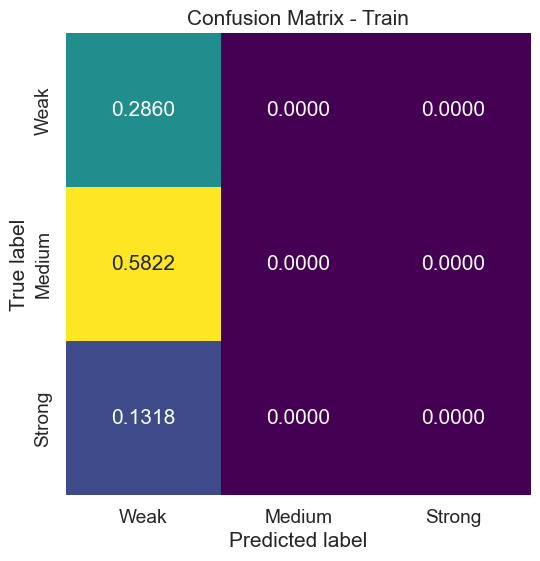

In [100]:
y_pred_train= history.model.predict(X_ML_train)
y_pred_train = np.argmax(y_pred_train, axis=1)
cfm = confusion_matrix(y_ML_train, y_pred_train, normalize="all")

cfm_df = pd.DataFrame(cfm, index=["Weak", "Medium", "Strong"], columns=["Weak", "Medium", "Strong"])

plt.figure(figsize=(6, 6))
sns.heatmap(cfm_df, annot=True, cmap='viridis', fmt='.4f', cbar=False, linewidths=0, linecolor=None)
plt.title("Confusion Matrix - Train")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

3/3 [==============================] - 0s 2ms/step


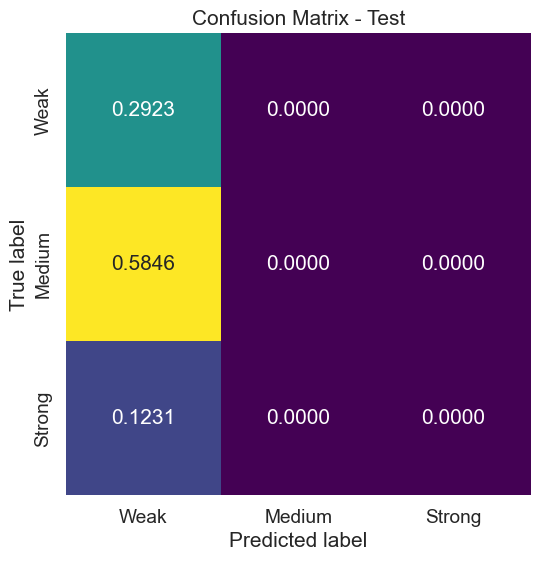

In [101]:
y_pred_test= history.model.predict(X_ML_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
cfm = confusion_matrix(y_ML_test, y_pred_test, normalize="all")

cfm_df = pd.DataFrame(cfm, index=["Weak", "Medium", "Strong"], columns=["Weak", "Medium", "Strong"])

plt.figure(figsize=(6, 6))
sns.heatmap(cfm_df, annot=True, cmap='viridis', fmt='.4f', cbar=False, linewidths=0, linecolor=None)
plt.title("Confusion Matrix - Test")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## Convulational Neural Network Models

In [102]:
def one_hot_encode_dna(sequences):
    # dictionary for coding
    mapping = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'N': [0, 0, 0, 0] 
    }
    
    # obtain length of sequences and number of sequences
    seq_length = len(sequences[0])
    num_sequences = len(sequences)
    
    # empty matrix for encoded sequences
    one_hot_encoded = np.zeros((num_sequences, seq_length, 4), dtype=np.int8)
    
    # fill matrix with encoded values
    for i, seq in enumerate(sequences):
        for j, nucleotide in enumerate(seq):
            one_hot_encoded[i, j, :] = mapping.get(nucleotide, [0, 0, 0, 0])
    
    return one_hot_encoded

In [103]:
X_cnn_train = list(df_train["Promoter sequence"].str.upper())
X_cnn_train = one_hot_encode_dna(X_cnn_train)

X_cnn_test = list(df_test["Promoter sequence"].str.upper())
X_cnn_test = one_hot_encode_dna(X_cnn_test)

In [104]:
y_cnn_train = df_train["Strength"]
y_cnn_test = df_test["Strength"]

In [105]:
y_cnn_train = np.array(y_cnn_train).astype(np.float32).reshape(-1, 1)
y_cnn_test = np.array(y_cnn_test).astype(np.float32).reshape(-1, 1)
y_cnn_train = to_categorical(y_cnn_train)
y_cnn_test = to_categorical(y_cnn_test)

### Inception model

In [106]:
X_cnn_train.shape

(584, 81, 4)

In [107]:
# input of the model
inputs = Input(shape=(X_cnn_train.shape[1], X_cnn_train.shape[2]))

# tower 1 for transcription factor detection
tower_1 = Conv1D(filters=40, kernel_size=18, activation='relu', padding='same')(inputs)
tower_1 = BatchNormalization()(tower_1)
tower_1 = MaxPooling1D(pool_size=2, strides=2)(tower_1)
tower_1 = Dropout(0.7)(tower_1)

# tower 2 for boxes -35 and -10 detection
tower_2 = Conv1D(filters=40, kernel_size=6, activation='relu', padding='same')(inputs)
tower_2 = BatchNormalization()(tower_2)
tower_2 = MaxPooling1D(pool_size=2, strides=2)(tower_2)
tower_2 = Dropout(0.7)(tower_2)

# concatenate towers
together = Concatenate(axis=-1)([tower_1, tower_2])

x = MaxPooling1D(pool_size=2, strides=2)(together)
x = Dropout(0.7)(x)
x = Flatten()(x)

# multilayer
x = Dense(70, activation='relu')(x)

# output layer
x = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()
history = model.fit(X_cnn_train, y_cnn_train, epochs=200, batch_size=32, validation_split=0.10)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 81, 4)]      0           []                               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 81, 40)       2920        ['input_3[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 81, 40)       1000        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 81, 40)      160         ['conv1d_5[0][0]']               
 rmalization)                                                                               

In [108]:
loss_train, accuracy_train = history.model.evaluate(X_cnn_train, y_cnn_train)
loss_test, accuracy_test = history.model.evaluate(X_cnn_test, y_cnn_test)
print('----TRAIN----')
print(f'Loss: {loss_train}, Accuracy: {accuracy_train}')
print('----TEST----')
print(f'Loss: {loss_test}, Accuracy: {accuracy_test}')

19/19 [==============================] - 0s 3ms/step - loss: 0.3434 - accuracy: 0.9366
----TRAIN----
Loss: 0.343415766954422, Accuracy: 0.9366438388824463
3/3 [==============================] - 0s 4ms/step - loss: 1.0906 - accuracy: 0.5077
----TEST----
Loss: 1.0906163454055786, Accuracy: 0.5076923370361328


19/19 [==============================] - 0s 3ms/step


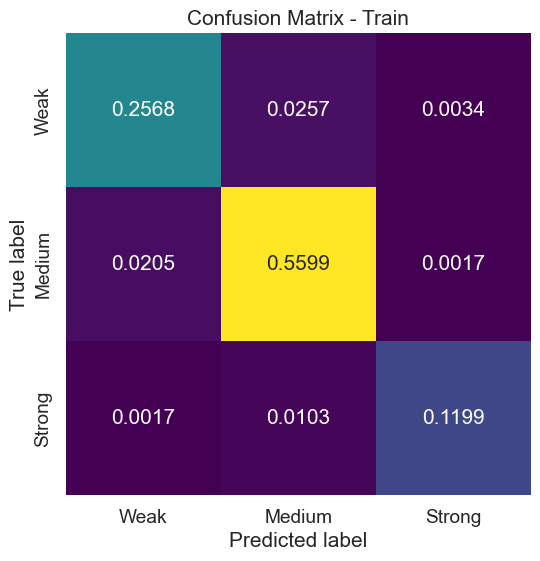

In [109]:
y_pred_train= history.model.predict(X_cnn_train)
y_pred_train = np.argmax(y_pred_train, axis=1)
y_cnn_train_cfm = np.argmax(y_cnn_train, axis=1)
cfm = confusion_matrix(y_cnn_train_cfm, y_pred_train, normalize="all")
cfm_df = pd.DataFrame(cfm, index=["Weak", "Medium", "Strong"], columns=["Weak", "Medium", "Strong"])

plt.figure(figsize=(6, 6))

sns.heatmap(cfm_df, annot=True, cmap='viridis', fmt='.4f', cbar=False, linewidths=0, linecolor=None)

plt.title("Confusion Matrix - Train")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

3/3 [==============================] - 0s 3ms/step


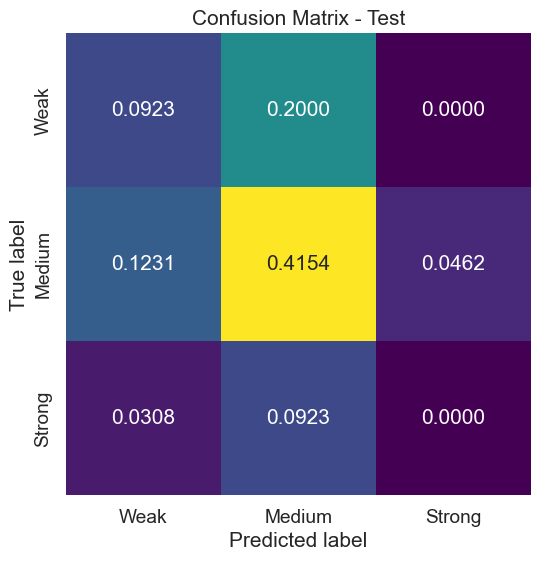

In [110]:
y_pred_test= history.model.predict(X_cnn_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
y_cnn_test_cfm = np.argmax(y_cnn_test, axis=1)
cfm = confusion_matrix(y_cnn_test_cfm, y_pred_test, normalize="all")

cfm_df = pd.DataFrame(cfm, index=["Weak", "Medium", "Strong"], columns=["Weak", "Medium", "Strong"])

plt.figure(figsize=(6, 6))
sns.heatmap(cfm_df, annot=True, cmap='viridis', fmt='.4f', cbar=False, linewidths=0, linecolor=None)
plt.title("Confusion Matrix - Test")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

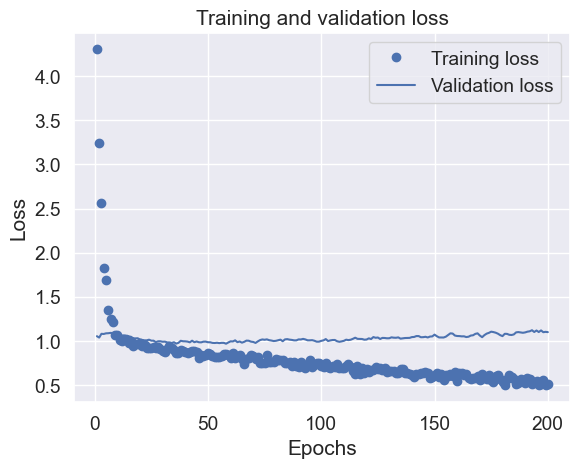

In [111]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

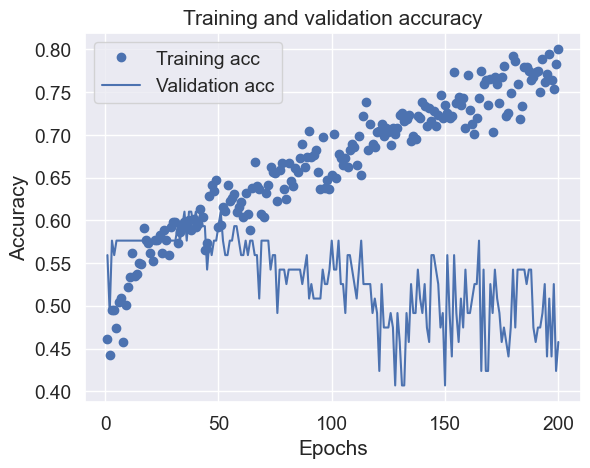

In [112]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Inception regularizers

In [113]:
inputs = Input(shape=(X_cnn_train.shape[1], X_cnn_train.shape[2]))

# first tower for transcription factors
tower_1 = Conv1D(filters=30, kernel_size=18, kernel_regularizer=regularizers.l1(0.001), activation='relu', padding='same')(inputs)
tower_1 = MaxPooling1D(pool_size=2)(tower_1)
tower_1 = Dropout(0.7)(tower_1)

# second tower for -35 and -10 boxes
tower_2 = Conv1D(filters=30, kernel_size=6, kernel_regularizer=regularizers.l1(0.001), activation='relu', padding='same')(inputs)
tower_2 = MaxPooling1D(pool_size=2)(tower_2)
tower_2 = Dropout(0.7)(tower_2)

# third tower for whole promoters
tower_3 = Conv1D(filters=20, kernel_size=30, kernel_regularizer=regularizers.l1(0.001), activation='relu', padding='same')(inputs)
tower_3 = MaxPooling1D(pool_size=2)(tower_3)
tower_3 = Dropout(0.4)(tower_3)

# concatenate towers
together = Concatenate(axis=-1)([tower_1, tower_2, tower_3])

# aditional layers
x = MaxPooling1D(pool_size=5)(together)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(10, activation='relu')(x)
x = Dense(3, activation='softmax')(x) 

model = Model(inputs=inputs, outputs=x)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_cnn_train, y_cnn_train, epochs=100, batch_size=32, validation_split=0.3)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 81, 4)]      0           []                               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 81, 30)       2190        ['input_4[0][0]']                
                                                                                                  
 conv1d_8 (Conv1D)              (None, 81, 30)       750         ['input_4[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 81, 20)       2420        ['input_4[0][0]']                
                                                                                            

In [114]:
loss_train, accuracy_train = history.model.evaluate(X_cnn_train, y_cnn_train)
loss_test, accuracy_test = history.model.evaluate(X_cnn_test, y_cnn_test)
print('----TRAIN----')
print(f'Loss: {loss_train}, Accuracy: {accuracy_train}')
print('----TEST----')
print(f'Loss: {loss_test}, Accuracy: {accuracy_test}')

19/19 [==============================] - 0s 3ms/step - loss: 0.6019 - accuracy: 0.8647
----TRAIN----
Loss: 0.6018663048744202, Accuracy: 0.8647260069847107
3/3 [==============================] - 0s 3ms/step - loss: 1.1100 - accuracy: 0.5846
----TEST----
Loss: 1.1100437641143799, Accuracy: 0.5846154093742371


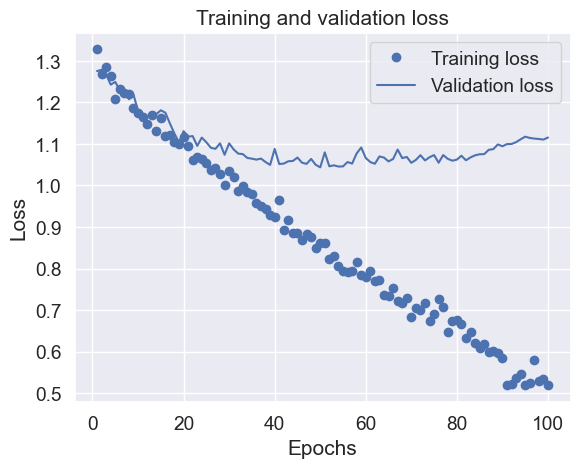

<Figure size 640x480 with 0 Axes>

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.clf()


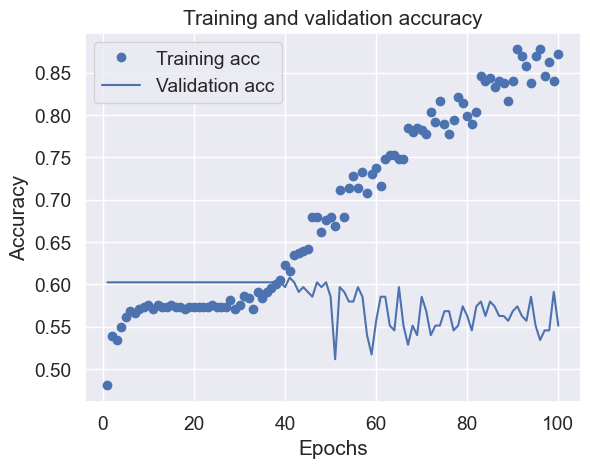

In [116]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

19/19 [==============================] - 0s 3ms/step


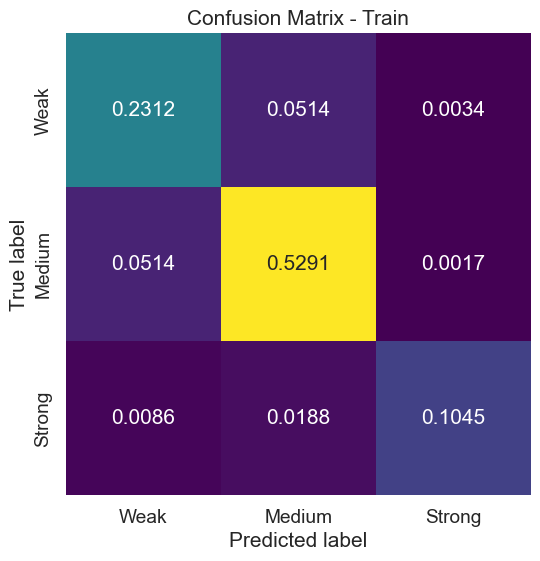

In [117]:
y_pred_train= history.model.predict(X_cnn_train)
y_pred_train = np.argmax(y_pred_train, axis=1)
y_cnn_train_cfm = np.argmax(y_cnn_train, axis=1)
cfm = confusion_matrix(y_cnn_train_cfm, y_pred_train, normalize="all")

cfm_df = pd.DataFrame(cfm, index=["Weak", "Medium", "Strong"], columns=["Weak", "Medium", "Strong"])

plt.figure(figsize=(6, 6))

sns.heatmap(cfm_df, annot=True, cmap='viridis', fmt='.4f', cbar=False, linewidths=0, linecolor=None)

plt.title("Confusion Matrix - Train")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

3/3 [==============================] - 0s 3ms/step


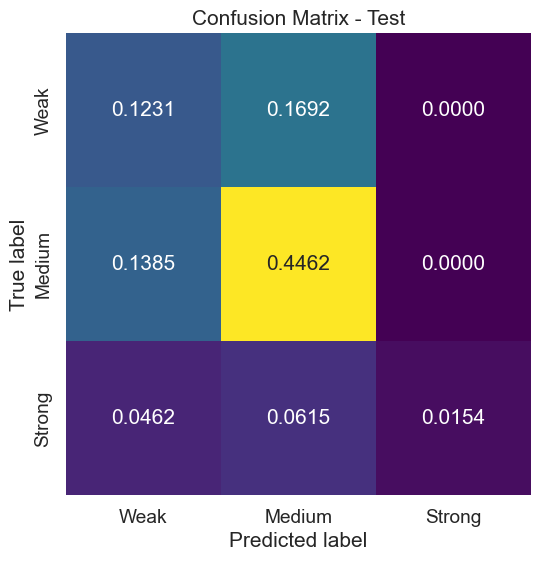

In [118]:
y_pred_test= history.model.predict(X_cnn_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
y_cnn_test_cfm = np.argmax(y_cnn_test, axis=1)
cfm = confusion_matrix(y_cnn_test_cfm, y_pred_test, normalize="all")

cfm_df = pd.DataFrame(cfm, index=["Weak", "Medium", "Strong"], columns=["Weak", "Medium", "Strong"])

plt.figure(figsize=(6, 6))

sns.heatmap(cfm_df, annot=True, cmap='viridis', fmt='.4f', cbar=False, linewidths=0, linecolor=None)

plt.title("Confusion Matrix - Test")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()